# 2D Data Preprocessing

In [1]:
import os
import glob
import pydicom
import pandas as pd

DATA_DIR = "train/"
patients = os.listdir(DATA_DIR)
train_image_files = sorted(glob.glob(os.path.join(DATA_DIR, '*','*.dcm')))

labels_df = pd.read_csv("train.csv", index_col=0)

In [2]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 80    # recommended minimum: 70
SAVE_FILE = "{}data-{}x{}.npy".format("masked-train", IMG_SIZE, IMG_SIZE)

In [4]:
from skimage import measure, morphology, segmentation
import scipy.ndimage as ndimage
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
from sklearn.cluster import KMeans

def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0


    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

In [5]:
def mean(l):
    return sum(l)/len(l)

def normalize(a):
    a[a < 0] = 0
    norm = np.linalg.norm(a)
    if norm == 0:
        return a
    return a / norm


def process_data(patient, labels_df, img_px_size=70):
    
    print(patient)
    path = os.path.join(DATA_DIR, patient)
    slices = [pydicom.read_file(os.path.join(path, file)) for file in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2])) # sorts images serially
    
    FVC = np.array(labels_df.at[patient, "FVC"])
    Weeks = np.array(labels_df.at[patient, "Weeks"])
    m, b = np.polyfit(Weeks, FVC, 1) # y = m*x + b; where x = Weeks, and y = FVC
    
    new_slices = []
    slopes = []
    intercepts = []
   
    for each_slice in slices:
        new_slices.append(cv2.resize(normalize(make_lungmask(each_slice.pixel_array)), (img_px_size, img_px_size)))
        slopes.append(-m)
        intercepts.append(b)

        
    '''
    Obtain slope of FVC Score as label
    Possibly check R^2 values as a counterpart to confidence score
    Check if non-linear functions describe FVC trends better than linear functions
    If so, brainstorm a numeric readout (to replace slope) from the non-linear f(x) that works best
    '''
    
   
    return np.array(new_slices), np.array(slopes), np.array(intercepts)

In [7]:
much_data = []
slopes_data = [] 
intercepts_data = []
num_key_errors = 0
num_run_errors = 0
num_att_errors = 0
num_val_errors = 0

for patient in patients:
    
    """
    This is a work-around for files that require GDCM to read. Try implementing get_pixeldata() method.
    """      
    try:
        img_data, slopes_data, intercepts_data = process_data(patient, 
                                                              labels_df, 
                                                              img_px_size=IMG_SIZE) 
        
        """Try a dictionary for img_data to make the dimensions the same across *_data"""
        much_data += zip(img_data, slopes_data, intercepts_data)
        
        
    except KeyError:
        print("Unlabeled data!") # error that Sentdex handled
        num_key_errors += 1
        
    except RuntimeError:
        print("GDCM required!") # error that requires GDCM dependency
        num_run_errors += 1
        
    except AttributeError:
        print("Missing ImagePositionPatient!")
        num_att_errors += 1    
  
    except ValueError:
        print("Input contains NaN, infinity or a value too large for dtype('float64')")
        num_val_errors += 1
    
np.save(SAVE_FILE, much_data, allow_pickle=True)
print("Save successful!")

if num_key_errors:
    print("KeyErrors: {}".format(num_key_errors))
if num_run_errors:
    print("Runtime Errors: {}".format(num_run_errors))
if num_att_errors:
    print("Attribute Errors: {}".format(num_att_errors))
if num_val_errors:
    print("Value Errors: {}".format(num_val_errors))

ID00007637202177411956430
ID00009637202177434476278
ID00010637202177584971671
ID00011637202177653955184
GDCM required!
ID00012637202177665765362
ID00014637202177757139317
ID00015637202177877247924
ID00019637202178323708467
ID00020637202178344345685
ID00023637202179104603099
ID00025637202179541264076
ID00026637202179561894768
Missing ImagePositionPatient!
ID00027637202179689871102
ID00030637202181211009029
ID00032637202181710233084
ID00035637202182204917484
ID00038637202182690843176
ID00042637202184406822975
ID00047637202184938901501
ID00048637202185016727717
ID00051637202185848464638
ID00052637202186188008618
GDCM required!
ID00060637202187965290703
ID00061637202188184085559
ID00062637202188654068490
ID00067637202189903532242
ID00068637202190879923934
ID00072637202198161894406
ID00073637202198167792918
ID00075637202198610425520
ID00076637202199015035026
ID00077637202199102000916
ID00078637202199415319443
ID00082637202201836229724
ID00086637202203494931510
ID00089637202204675567570
ID00

<ipython-input-4-2599e30f5f34>:14: RuntimeWarning: invalid value encountered in true_divide
  img = img/std


Input contains NaN, infinity or a value too large for dtype('float64')
ID00108637202209619669361
ID00109637202210454292264
ID00110637202210673668310
ID00111637202210956877205
ID00115637202211874187958
ID00117637202212360228007
ID00119637202215426335765
ID00122637202216437668965
ID00123637202217151272140
ID00124637202217596410344
ID00125637202218590429387
ID00126637202218610655908
ID00127637202219096738943
ID00128637202219474716089
Missing ImagePositionPatient!
ID00129637202219868188000
ID00130637202220059448013
ID00131637202220424084844
ID00132637202222178761324
Missing ImagePositionPatient!
ID00133637202223847701934
ID00134637202223873059688
ID00135637202224630271439
ID00136637202224951350618
ID00138637202231603868088
ID00139637202231703564336
ID00140637202231728595149
ID00149637202232704462834
ID00161637202235731948764
ID00165637202237320314458
ID00167637202237397919352
ID00168637202237852027833
ID00169637202238024117706
ID00170637202238079193844
ID00172637202238316925179
ID001736372

In [8]:
print(much_data[0])

(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 3.167125870069571, 2174.4161832946634)


In [9]:
np.shape(much_data[0][0])

(80, 80)

In [10]:
# much_data[529][2]

In [11]:
images = np.load(SAVE_FILE, allow_pickle=True)
images.shape

(31937, 3)

In [12]:
print(images)

[[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
  3.167125870069571 2174.4161832946634]
 [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
  3.167125870069571 2174.4161832946634]
 [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
  3.167125870069571 2174.4161832946634]
 ...
 [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0.

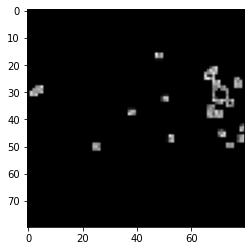

In [13]:
plt.imshow(images[0][0], cmap='gray')